In [8]:
%pip install small-text[transformers]==1.3.3   # use "small-text" without "[transformers]" if you want to work on the CPU only

# additional dependencies for this example
%pip install datasets matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.7/205.7 kB 1.9 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [10]:
import logging
import datasets

raw_dataset = datasets.load_dataset('rotten_tomatoes')
num_classes = raw_dataset['train'].features['label'].num_classes

print('First 10 training samples:\n')
for i in range(10):
    print(raw_dataset['train']['label'][i], ' ', raw_dataset['train']['text'][i])

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

First 10 training samples:

1   the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .
1   the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .
1   effective but too-tepid biopic
1   if you sometimes like to go to the movies to have fun , wasabi is a good place to start .
1   emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .
1   the film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .
1   offers that rare combination of entertainment and education .
1   perhaps no picture ever made has more literally showed that the road to hell is paved with good inten

In [12]:
from transformers import AutoTokenizer

transformer_model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(
    transformer_model_name
)

In [14]:
from small_text import TransformersDataset
import numpy as np

target_labels = np.arange(num_classes)

train = TransformersDataset.from_arrays(raw_dataset['train']['text'],
                                        raw_dataset['train']['label'],
                                        tokenizer,
                                        max_length=60,
                                        target_labels=target_labels)
test = TransformersDataset.from_arrays(raw_dataset['test']['text'], 
                                       raw_dataset['test']['label'],
                                       tokenizer,
                                       max_length=60,
                                       target_labels=target_labels)

/opt/conda/lib/python3.10/site-packages/small_text/utils/annotations.py:67: ExperimentalWarning: The function from_arrays is experimental and maybe subject to change soon.
  warnings.warn(f'The {subject} {func_or_class.__name__} is experimental '


In [15]:
from small_text import (
    PoolBasedActiveLearner,
    PredictionEntropy,
    TransformerBasedClassificationFactory,
    TransformerModelArguments,
    random_initialization_balanced
)


# simulates an initial labeling to warm-start the active learning process
def initialize_active_learner(active_learner, y_train):

    indices_initial = random_initialization_balanced(y_train, n_samples=20)
    active_learner.initialize_data(indices_initial, y_train[indices_initial])

    return indices_initial


transformer_model = TransformerModelArguments(transformer_model_name)
clf_factory = TransformerBasedClassificationFactory(transformer_model, 
                                                    num_classes, 
                                                    kwargs=dict({'device': 'cuda', 
                                                                 'mini_batch_size': 32,
                                                                 'class_weight': 'balanced'
                                                                }))
query_strategy = PredictionEntropy()

active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train)
indices_labeled = initialize_active_learner(active_learner, train.y)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [16]:
from sklearn.metrics import accuracy_score


num_queries = 10


def evaluate(active_learner, train, test):
    y_pred = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)
    
    test_acc = accuracy_score(y_pred_test, test.y)

    print('Train accuracy: {:.2f}'.format(accuracy_score(y_pred, train.y)))
    print('Test accuracy: {:.2f}'.format(test_acc))
    
    return test_acc


results = []
results.append(evaluate(active_learner, train[indices_labeled], test))

    
for i in range(num_queries):
    # ...where each iteration consists of labelling 20 samples
    indices_queried = active_learner.query(num_samples=20)

    # Simulate user interaction here. Replace this for real-world usage.
    y = train.y[indices_queried]

    # Return the labels for the current query to the active learner.
    active_learner.update(y)

    indices_labeled = np.concatenate([indices_queried, indices_labeled])
    
    print('---------------')
    print(f'Iteration #{i} ({len(indices_labeled)} samples)')
    results.append(evaluate(active_learner, train[indices_labeled], test))


Train accuracy: 0.95
Test accuracy: 0.57
---------------
Iteration #0 (40 samples)
Train accuracy: 0.55
Test accuracy: 0.50
---------------
Iteration #1 (60 samples)
Train accuracy: 0.95
Test accuracy: 0.74
---------------
Iteration #2 (80 samples)
Train accuracy: 0.99
Test accuracy: 0.64
---------------
Iteration #3 (100 samples)
Train accuracy: 0.98
Test accuracy: 0.67
---------------
Iteration #4 (120 samples)
Train accuracy: 0.96
Test accuracy: 0.66
---------------
Iteration #5 (140 samples)
Train accuracy: 0.94
Test accuracy: 0.61
---------------
Iteration #6 (160 samples)
Train accuracy: 0.97
Test accuracy: 0.70
---------------
Iteration #7 (180 samples)
Train accuracy: 0.94
Test accuracy: 0.76
---------------
Iteration #8 (200 samples)
Train accuracy: 0.96
Test accuracy: 0.72
---------------
Iteration #9 (220 samples)
Train accuracy: 0.98
Test accuracy: 0.78


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


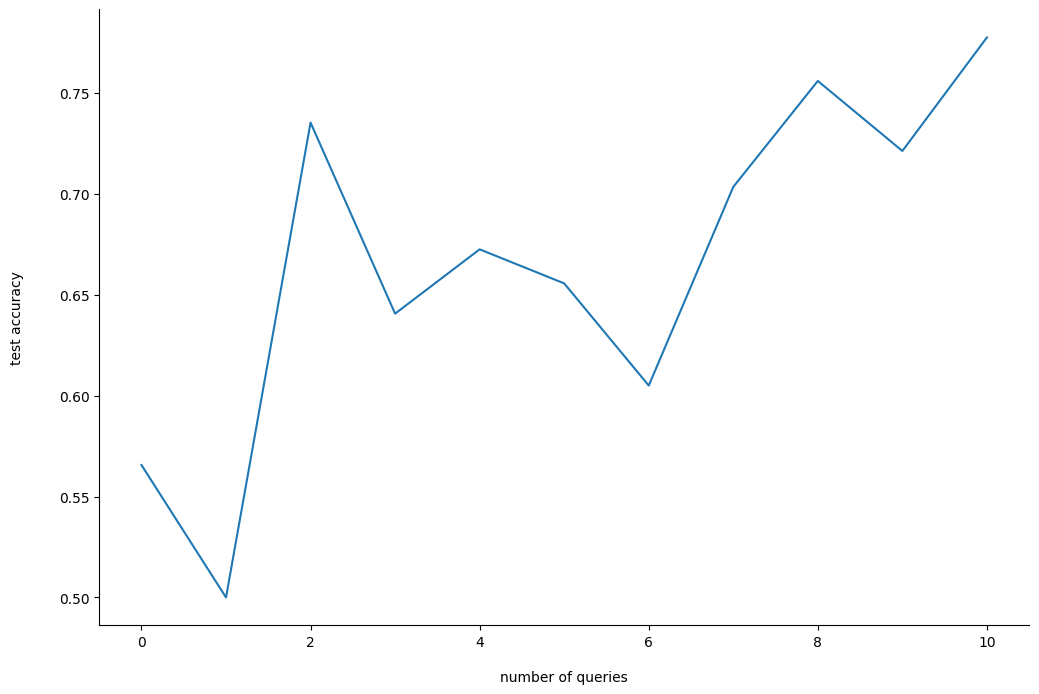

In [17]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = plt.axes()

data = np.vstack((np.arange(num_queries+1), np.array(results)))
sns.lineplot(x=0, y=1, data=data)

plt.xlabel('number of queries', labelpad=15)
plt.ylabel('test accuracy', labelpad=25)

sns.despine()